# Analysis of Yelp Business Intelligence Data

We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from [Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset) although we have taken steps to pull this data into a publis s3 bucket: `s3://sta9760-yelpdataset/yelp-light/*business.json`

# Installation and Initial Setup

Begin by installing the necessary libraries that you may need to conduct your analysis. At the very least, you must install `pandas` and `matplotlib`

In [1]:
%%info

In [2]:
sc.list_packages()

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1619295161195_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version  
-------------------------- ---------
beautifulsoup4             4.9.1    
boto                       2.49.0   
click                      7.1.2    
jmespath                   0.10.0   
joblib                     0.16.0   
lxml                       4.5.2    
mysqlclient                1.4.2    
nltk                       3.5      
nose                       1.3.4    
numpy                      1.16.5   
pip                        9.0.1    
py-dateutil                2.2      
python37-sagemaker-pyspark 1.4.0    
pytz                       2020.1   
PyYAML                     5.3.1    
regex                      2020.7.14
setuptools                 28.8.0   
six                        1.13.0   
soupsieve                  1.9.5    
tqdm                       4.48.2   
wheel                      0.29.0   
windmill                   1.6

In [3]:
#Install dependencies.
sc.install_pypi_package("pandas==1.2.4")
sc.install_pypi_package("matplotlib==3.4.1")
sc.install_pypi_package("seaborn==0.11.1")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Importing

Now, import the installed packages from the previous block below.

In [4]:
#Import libraries needed to analyze the dataset.
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading Data

We are finally ready to load data. Using `spark` load the data from S3 into a `dataframe` object that we can manipulate further down in our analysis.

In [5]:
#Load data and read it.
df_business = spark.read.json('s3://sta9760s2021-project02-datasets/yelp_academic_dataset_business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Overview of Data

Display the number of rows and columns in our dataset.

In [6]:
#Number of columns and rows.
print(f'Columns: {len(df_business.dtypes)} | Rows: {df_business.count()}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Columns: 14 | Rows: 160585

Display the DataFrame schema below.

In [7]:
#View the schema of the dataset.
df_business.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Display the first 5 rows with the following columns:

* `business_id`
* `name`
* `city`
* `state`
* `categories`

In [8]:
#List first 5 rows of the dataset.
df_business.select('business_id','name','city','state','categories').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-----------+-----+--------------------+
|         business_id|                name|       city|state|          categories|
+--------------------+--------------------+-----------+-----+--------------------+
|6iYb2HFDywm3zjuRg...| Oskar Blues Taproom|    Boulder|   CO|Gastropubs, Food,...|
|tCbdrRPZA0oiIYSmH...|Flying Elephants ...|   Portland|   OR|Salad, Soup, Sand...|
|bvN78flM8NLprQ1a1...|      The Reclaimory|   Portland|   OR|Antiques, Fashion...|
|oaepsyvc0J17qwi8c...|         Great Clips|Orange City|   FL|Beauty & Spas, Ha...|
|PE9uqAjdw0E4-8mjG...|   Crossfit Terminus|    Atlanta|   GA|Gyms, Active Life...|
+--------------------+--------------------+-----------+-----+--------------------+
only showing top 5 rows

# Analyzing Categories

Let's now answer this question: **how many unique categories are represented in this dataset?**

Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:

* How many businesses are categorized as `Active Life`, for instance
* What are the top 20 most popular categories available?

## Association Table

We need to "break out" these categories from the business ids? One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

For instance, given the following:


| business_id | categories |
|-------------|------------|
| abcd123     | a,b,c      |

We would like to derive something like:

| business_id | category |
|-------------|------------|
| abcd123     | a          |
| abcd123     | b          |
| abcd123     | c          |


What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

Implement the code necessary to derive the table described from your original yelp dataframe.

In [9]:
from pyspark.sql.functions import explode, split
df_business_category = df_business.withColumn('category', explode(split('categories',', ')))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Display the first 5 rows of your association table below.

In [10]:
#Pick only business_id and category columns and show the first 5 rows.
df_business_category.select('business_id','category').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+
|         business_id|    category|
+--------------------+------------+
|6iYb2HFDywm3zjuRg...|  Gastropubs|
|6iYb2HFDywm3zjuRg...|        Food|
|6iYb2HFDywm3zjuRg...|Beer Gardens|
|6iYb2HFDywm3zjuRg...| Restaurants|
|6iYb2HFDywm3zjuRg...|        Bars|
+--------------------+------------+
only showing top 5 rows

## Total Unique Categories

Finally, we are ready to answer the question: **what is the total number of unique categories available?**

Below, implement the code necessary to calculate this figure.

In [11]:
# Find unique business categories.
df_business_category.select('category').distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1330

## Top Categories By Business

Now let's find the top categories in this dataset by rolling up categories.

### Counts of Businesses / Category

So now, let's unroll our distinct count a bit and display the per count value of businesses per category.

The expected output should be:

| category | count |
|-------------|------------|
| a     | 15         |
| b     | 2          |
| c     | 45          |

Or something to that effect.

In [12]:
#Count and show the number of businesses by unique categories.
category_count = df_business_category.groupby("category").count()
category_count.show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|            category|count|
+--------------------+-----+
|      Dermatologists|  351|
|      Paddleboarding|   67|
|        Aerial Tours|    8|
|         Hobby Shops|  610|
|          Bubble Tea|  779|
|             Embassy|    9|
|             Tanning|  701|
|            Handyman|  507|
|      Aerial Fitness|   13|
|             Falafel|  141|
|        Summer Camps|  308|
|       Outlet Stores|  184|
|     Clothing Rental|   37|
|      Sporting Goods| 1864|
|     Cooking Schools|  114|
|  College Counseling|   20|
|  Lactation Services|   47|
|Ski & Snowboard S...|   55|
|             Museums|  336|
|              Doulas|   52|
+--------------------+-----+
only showing top 20 rows

### Bar Chart of Top Categories

With this data available, let us now build a barchart of the top 20 categories. 

**HINT**: don't forget about the matplotlib magic!

```
%matplot plt
```

In [13]:
#Find top 20 business categories.
top_20_category=category_count.sort('count',ascending=False).limit(20).toPandas().set_index('category','count')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
#View top 20 business categories.
top_20_category

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                           count
category                        
Restaurants                50763
Food                       29469
Shopping                   26205
Beauty & Spas              16574
Home Services              16465
Health & Medical           15102
Local Services             12192
Nightlife                  11990
Bars                       10741
Automotive                 10119
Event Planning & Services   9644
Active Life                 9231
Coffee & Tea                7725
Sandwiches                  7272
Fashion                     6599
American (Traditional)      6541
Hair Salons                 5900
Pizza                       5756
Hotels & Travel             5703
Breakfast & Brunch          5505

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

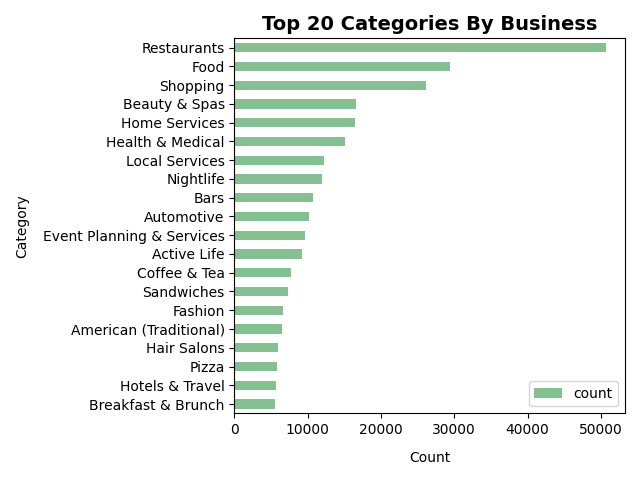

In [15]:
#Create a bar chart to visualize top 20 business categories.
bar_chart = top_20_category.plot.barh(color='#86bf91')

bar_chart.invert_yaxis()

#bar_chart.tick_params(axis="both", which="both", labelbottom="on", labelleft="on")

bar_chart.set_xlabel("Count", labelpad=10, size=10)

bar_chart.set_ylabel("Category", labelpad=10,  size=10)

bar_chart.set_title("Top 20 Categories By Business", weight='bold', size=14)

plt.tight_layout()

%matplot plt

# Do Yelp Reviews Skew Negative?

Oftentimes, it is said that the only people who write a written review are those who are extremely _dissatisfied_ or extremely _satisfied_ with the service received. 

How true is this really? Let's try and answer this question.

## Loading User Data

Begin by loading the user data set from S3 and printing schema to determine what data is available.

In [16]:
#Load and read the dataset.
df_review = spark.read.json('s3://sta9760s2021-project02-datasets/yelp_academic_dataset_review.json')
df_review.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

In [17]:
#Find the number of columns and rows.
print(f'Columns: {len(df_review.dtypes)} | Rows: {df_review.count()}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Columns: 9 | Rows: 8635403

Let's begin by listing the `business_id` and `stars` columns together for the user reviews data.

In [18]:
#Pick only business_id and stars columns.
df_review.select('business_id','stars').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|buF9druCkbuXLX526...|  4.0|
|RA4V8pr014UyUbDvI...|  4.0|
|_sS2LBIGNT5NQb6PD...|  5.0|
|0AzLzHfOJgL7ROwhd...|  2.0|
|8zehGz9jnxPqXtOc7...|  4.0|
+--------------------+-----+
only showing top 5 rows

Now, let's aggregate along the `stars` column to get a resultant dataframe that displays _average stars_ per business as accumulated by users who **took the time to submit a written review**.

In [19]:
#Find average stars for each business entity.
df_biz_avg_stars = df_review.groupBy('business_id').mean('stars')
df_biz_avg_stars.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------------+
|         business_id|       avg(stars)|
+--------------------+-----------------+
|yHtuNAlYKtRZniO8O...|4.714285714285714|
|R0IJhEI-zSJpYT1YN...|3.606060606060606|
|uEUweopM30lHcVxjO...|              3.0|
|L3WCfeVozu5etMhz4...|              4.2|
|XzXcpPCb8Y5huklEN...|4.666666666666667|
+--------------------+-----------------+
only showing top 5 rows

Now the fun part - let's join our two dataframes (reviews and business data) by `business_id`. 

In [20]:
#Join reviews and business datasets on business_id. Pick avg(stars),stars,name,city,state columns.
df_joined = df_biz_avg_stars.join(df_business,'business_id')
df_selected= df_joined.select('avg(stars)','stars','name','city','state')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's see a few of these:

In [21]:
#View the first 5 rows of the joined database.
df_selected.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+--------------------+----------+-----+
|        avg(stars)|stars|                name|      city|state|
+------------------+-----+--------------------+----------+-----+
|               5.0|  5.0|    CheraBella Salon|   Peabody|   MA|
|             3.875|  4.0|Mezcal Cantina & ...|  Columbus|   OH|
|3.8666666666666667|  4.0|    Red Table Coffee|    Austin|   TX|
|               5.0|  5.0|          WonderWell|    Austin|   TX|
|             3.375|  3.5|         Avalon Oaks|Wilmington|   MA|
+------------------+-----+--------------------+----------+-----+
only showing top 5 rows

Compute a new dataframe that calculates what we will call the _skew_ (for lack of a better word) between the avg stars accumulated from written reviews and the _actual_ star rating of a business (ie: the average of stars given by reviewers who wrote an actual review **and** reviewers who just provided a star rating).

The formula you can use is something like:

```
(row['avg(stars)'] - row['stars']) / row['stars']
```

If the **skew** is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If **skew** is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [22]:
#Create a new dataset to find skewness of each row.
df_skewed = df_selected.select('avg(stars)','stars').toPandas()
df_skewed['skew'] = (df_skewed['avg(stars)'] - df_skewed['stars']) / df_skewed['stars']
df_skewed

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

        avg(stars)  stars      skew
0         4.714286    4.5  0.047619
1         3.606061    3.5  0.030303
2         3.000000    3.0  0.000000
3         4.200000    4.0  0.050000
4         4.666667    4.5  0.037037
...            ...    ...       ...
160580    1.250000    1.0  0.250000
160581    5.000000    5.0  0.000000
160582    5.000000    5.0  0.000000
160583    4.789474    5.0 -0.042105
160584    3.533333    3.5  0.009524

[160585 rows x 3 columns]

And finally, graph it!

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

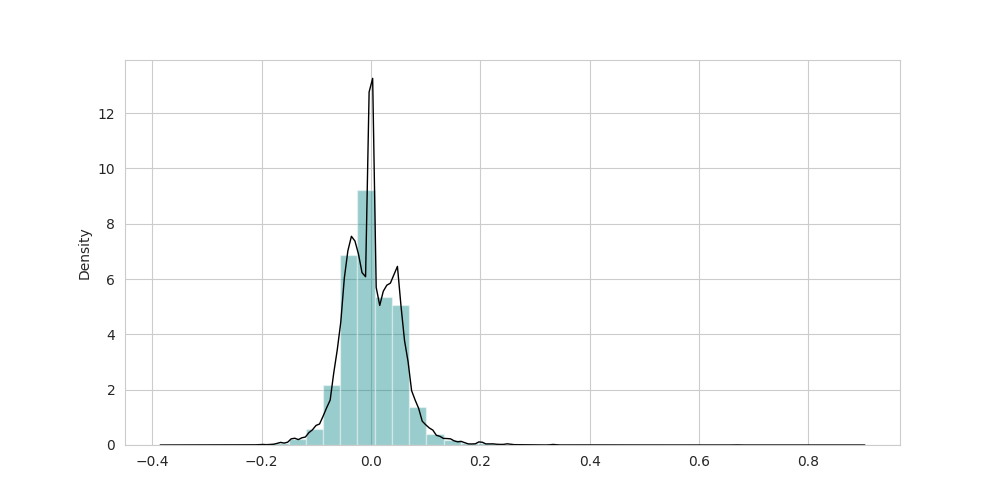

In [23]:
#Create a distribution plot.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
 
data = df_skewed['skew']
 
sns.set_style("whitegrid")
plt.figure(figsize = (10,5)) 
sns.distplot(x = data  ,  bins = 40 , kde = True , color = 'teal'\
             , kde_kws=dict(linewidth = 1 , color = 'black'))
plt.show()
%matplot plt

So, do Yelp (written) Reviews skew negative? Does this analysis actually prove anything? Expound on implications / interpretations of this graph. 

In order to comment on the graph more efficiently, a further calculation is needed. Because the distribution graph does not say much about the skewness, it looks like a normal distribution.

In [24]:
#Calculate skewness, kurtosis, meand and variance of the dataset.
#%matplotlib inline
import numpy as np
import pandas as pd
from scipy.stats import kurtosis
from scipy.stats import skew

import matplotlib.pyplot as plt

#plt.style.use('ggplot')

data = df_skewed['skew']
np.var(data)

#plt.hist(data, bins=60)

print("mean : ", np.mean(data))
print("var  : ", np.var(data))
print("skew : ",skew(data))
print("kurt : ",kurtosis(data))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

mean :  0.0011443037144630323
var  :  0.00264438245976947
skew :  0.8747412434133823
kurt :  7.971463600554722

When we analyze the entire dataset, the skew value is between 0.5-1. So, we can conclude the data are moderately positively skewed.

# Should the Elite be Trusted? (Or, some other analysis of your choice)

For the final portion - you have a choice:

* Try and analyze some interesting dimension to this data. The **ONLY** requirement is that you must use the **Users** dataset and join on either the **business* or **reviews** dataset
* Or, you may try and answer the question posed: how accurate or close are the ratings of an "elite" user (check Users table schema) vs the actual business rating.

Feel free to use any and all methodologies at your disposal - only requirement is you must render one visualization in your analysis

In [25]:
#Load and read the dataset.
df_user = spark.read.json('s3://sta9760s2021-project02-datasets/yelp_academic_dataset_user.json')
df_user.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

In [26]:
#Find the number of columns and rows.
print(f'Columns: {len(df_user.dtypes)} | Rows: {df_user.count()}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Columns: 22 | Rows: 2189457

In [27]:
#Filter only elite users and create a new dataset and user_id, elite.
df_only_elite= df_user.filter(df_user['elite'] != '').select('user_id', 'elite')
#Pick only business_id, stars, user_id columns from reviews dataset.
df_review_1 = df_review.select('business_id', 'stars', 'user_id')
#Joine only elite and review datasets on user_id.
df_joined_1 = df_only_elite.join(df_review_1, df_only_elite.user_id == df_review_1.user_id).drop(df_review_1['user_id'])
#View the first 5 columns
df_joined_1.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------------------+-----+
|             user_id|               elite|         business_id|stars|
+--------------------+--------------------+--------------------+-----+
|0JQYSCWOQWKqK7KMj...| 2015,2016,2017,2018|eCLuYcTuQpDPFOezh...|  4.0|
|l91pXxTZGS5CNWjNB...|2012,2013,2014,20...|RP_U_TyolABy3eYuR...|  3.0|
|WAyYDJKFMzlTTnKxq...|2011,2012,2013,20...|_6TF9YiOiYSToPBRz...|  5.0|
|g34Qcj06LmCDhKzks...|2017,2018,2019,20,20|bxy3khT-2R66tcdKj...|  4.0|
|_UMIAnpnXWAqXS4y6...|2015,2016,2017,20...|A0F6H8OO3qYAvI2L3...|  4.0|
+--------------------+--------------------+--------------------+-----+
only showing top 5 rows

In [28]:
#Find the number of columns and rows.
print(f'Columns: {len(df_joined_1.dtypes)} | Rows: {df_joined_1.count()}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Columns: 4 | Rows: 2169088

In [36]:
#Use df_biz_avg_stars dataset and combine it with df_join_1 dataset created on business_id. 
#This way, It is possible to see the average rating of the business and elite user's rating for the same business.
df_joined_2 = df_biz_avg_stars.join(df_joined_1 , df_joined_1.business_id == df_biz_avg_stars.business_id).drop(df_joined_1['business_id'])
df_joined_2.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+--------------------+--------------------+--------------------+-----+
|        avg(stars)|             user_id|               elite|         business_id|stars|
+------------------+--------------------+--------------------+--------------------+-----+
|               5.0|olrx_XfiOSiALGqmB...|      2016,2017,2018|--JuLhLvq3gyjNnXT...|  5.0|
|               5.0|jWi0LzO0jRpr6TMwo...|2016,2017,2018,20...|--JuLhLvq3gyjNnXT...|  5.0|
|             3.875|wEp-ZgJ6XpETVo1rs...|     2018,2019,20,20|--_nBudPOb1lNRgKf...|  5.0|
|             3.875|VatcQtdb5tlz4D-N6...|2014,2015,2016,20...|--_nBudPOb1lNRgKf...|  4.0|
|3.8666666666666667|VVBzicjxYIhE2RR3n...| 2010,2011,2012,2013|--kyOk0waSrCDlbSv...|  5.0|
+------------------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows

In [37]:
#Find the number of columns and rows.
print(f'Columns: {len(df_joined_2.dtypes)} | Rows: {df_joined_2.count()}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Columns: 5 | Rows: 2169088

In [38]:
# Add skew column to evaluate skewness for each record
df_joined_2 = df_joined_2.toPandas()
df_joined_2['skew'] = (df_joined_2['stars'] - df_joined_2['avg(stars)']) / df_joined_2['avg(stars)']
#Show the dataset after adding the new column
df_joined_2

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

         avg(stars)                 user_id  ... stars      skew
0          5.000000  olrx_XfiOSiALGqmB_PfSg  ...   5.0  0.000000
1          5.000000  jWi0LzO0jRpr6TMwo9anwQ  ...   5.0  0.000000
2          3.875000  wEp-ZgJ6XpETVo1rsYsuvA  ...   5.0  0.290323
3          3.875000  VatcQtdb5tlz4D-N6y8e7A  ...   4.0  0.032258
4          3.866667  VVBzicjxYIhE2RR3nUfOTA  ...   5.0  0.293103
...             ...                     ...  ...   ...       ...
2169083    3.092105  OdiOfb-5KQz6z54IQ8T5RA  ...   5.0  0.617021
2169084    4.215909  wX_Fgi0SkooBTnq-kGAD2Q  ...   5.0  0.185984
2169085    4.215909  2gas35gMf50hdkVeUxYQQg  ...   1.0 -0.762803
2169086    4.215909  f3xJJpUIFWmdZhhc912Leg  ...   4.0 -0.051213
2169087    4.789474  3XOTxkcpqttnxt52HcIN3Q  ...   5.0  0.043956

[2169088 rows x 6 columns]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

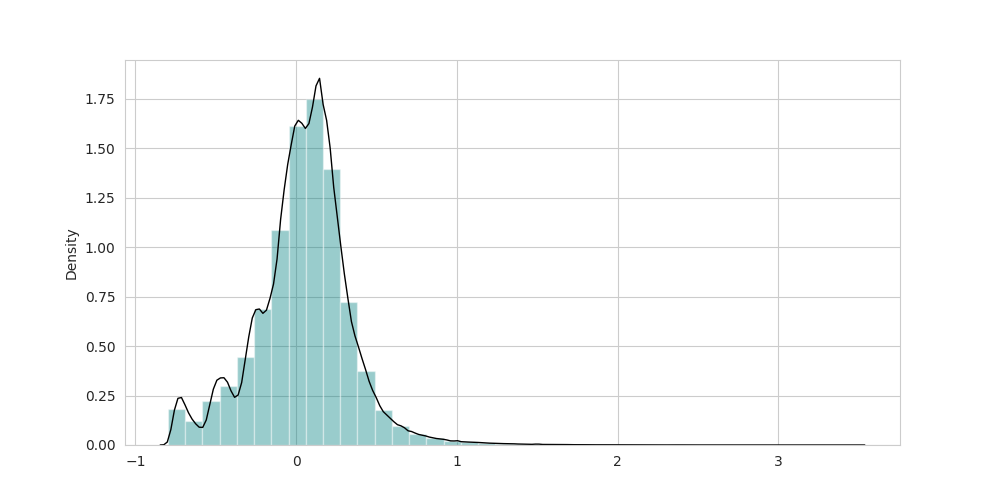

In [42]:
#Create a distribution plot.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
 
data1 = df_joined_2['skew']
 
sns.set_style("whitegrid")
plt.figure(figsize = (10,5)) 
sns.distplot(x = data1  ,  bins = 40 , kde = True , color = 'teal'\
             , kde_kws=dict(linewidth = 1 , color = 'black'))
plt.show()
%matplot plt

The bulk of the data is at the left and the right tail is longer. We canconclude that the distribution is skewed right or positively skewed. That means elite reviewers rate higher. But let's see how the skewness of the entire dataset looks like.

In [44]:
#Calculate skewness, kurtosis, meand and variance 
#%matplotlib inline
import numpy as np
import pandas as pd
from scipy.stats import kurtosis
from scipy.stats import skew

import matplotlib.pyplot as plt

#plt.style.use('ggplot')

data2 = df_joined_2['skew']
np.var(data2)

#plt.hist(data, bins=60)

print("mean : ", np.mean(data2))
print("var  : ", np.var(data2))
print("skew : ",skew(data2))
print("kurt : ",kurtosis(data2))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

mean :  0.04206012645991376
var  :  0.08890287096860526
skew :  0.21227265464834855
kurt :  2.9632099933445035

The skewness of the dataset is between 0-0.5. That means the distribution is approximately symmetric. So, elite reviewers do not show a different tendency in terms of ratings compared to an average user.

## Reviewers by State

This part is to figure out which 10 states have most reviewers.

In [61]:
#Join user and review datasets on business_id and show fisrt 5 rows.
df_joined_3=df_user.join(df_review,'user_id').select('user_id','business_id')
df_joined_3.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|             user_id|         business_id|
+--------------------+--------------------+
|--1UpCuUDJQbqiuFX...|GgR7kcKykuqXB11fW...|
|--3Bk72HakneTyp3D...|rxNfidGLHtMYyLNeo...|
|--3Hl2oAvTPlq-f7K...|bAuYOa-VuqTOnKzWN...|
|--3Hl2oAvTPlq-f7K...|vqQXI-Pxz3izeTUF6...|
|--3Hl2oAvTPlq-f7K...|2OaX6XjAoI7VD6jLd...|
+--------------------+--------------------+
only showing top 5 rows

In [62]:
#Pick only user_id and business_id columns and join with df_business on business_id. Show the first 5 rows.
df_biz_state=df_business.select('business_id','state')
df_joined_4 = df_joined_3.join(df_biz_state,'business_id')
df_joined_4.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-----+
|         business_id|             user_id|state|
+--------------------+--------------------+-----+
|GgR7kcKykuqXB11fW...|--1UpCuUDJQbqiuFX...|   GA|
|rxNfidGLHtMYyLNeo...|--3Bk72HakneTyp3D...|   FL|
|bAuYOa-VuqTOnKzWN...|--3Hl2oAvTPlq-f7K...|   CO|
|vqQXI-Pxz3izeTUF6...|--3Hl2oAvTPlq-f7K...|   CO|
|2OaX6XjAoI7VD6jLd...|--3Hl2oAvTPlq-f7K...|   CO|
+--------------------+--------------------+-----+
only showing top 5 rows

In [63]:
#Show the schema.
df_joined_4.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- state: string (nullable = true)

In [64]:
#Find the number of columns and rows.
print(f'Columns: {len(df_joined_4.dtypes)} | Rows: {df_joined_4.count()}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Columns: 3 | Rows: 8635403

In [65]:
#Group reviewers by state and count for each state.
df_reviewer_state = df_joined_4.select('user_id','state').groupby('state').count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [68]:
#Top 10 state with most reviewers
top_10_state = df_reviewer_state.sort('count',ascending=False).limit(10).toPandas().set_index('state','count')
top_10_state

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

         count
state         
MA     2084020
TX     1508210
OR     1445103
GA     1150884
FL     1131554
BC      622769
OH      430257
CO      142289
WA      119576
CA         225

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

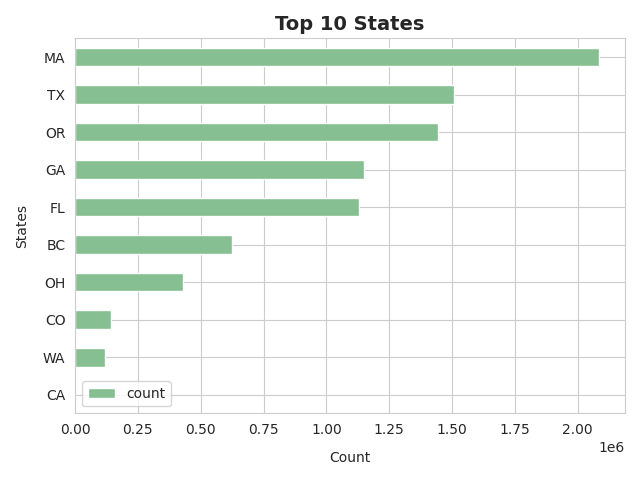

In [69]:
#Graph top 10 state with most reviewers
bar_chart_reviewer = top_10_state.plot.barh(color='#86bf91')

bar_chart_reviewer.invert_yaxis()

#bar_chart.tick_params(axis="both", which="both", labelbottom="on", labelleft="on")

bar_chart_reviewer.set_xlabel("Count", labelpad=10, size=10)

bar_chart_reviewer.set_ylabel("States", labelpad=10,  size=10)

bar_chart_reviewer.set_title("Top 10 States", weight='bold', size=14)

plt.tight_layout()

%matplot plt